In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
import time

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../../ESC-50/audio/'

In [5]:
path_to_db='../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_target
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


In [10]:
df = ps.preprocess_fold(dataset,
                        kind='quantized',
                        blocksize=blocksize,
                        overlap=overlap,
                        n_mels=128,
                        power_melgram=2.0,
                        decibel_gram=True,
                        feature_bag=False,
                        folds=3
                       )

In [11]:
df.head()

label,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,target,fold
0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,36,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,2
4,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,19,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [12]:
X_train = df[df.fold > 1].drop(['fold', 'target'], axis=1)
X_test = df[df.fold == 1].drop(['fold', 'target'], axis=1)
y_train = df[df.fold > 1]['target']
y_test = df[df.fold == 1]['target']

In [13]:
X_train.shape

(1333, 2048)

In [14]:
y_train.shape

(1333,)

# Deep Net
Separate into classes

In [22]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(2048,)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [23]:
clf = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=50, 
                       batch_size=35, 
                       validation_split=0.15)

history = clf.fit(X_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
__________

0.25487256371814093
Confusion matrix, without normalization
[[2 2 0 ... 0 0 0]
 [1 3 0 ... 0 0 0]
 [1 0 6 ... 2 1 1]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 1 3 0]
 [0 0 1 ... 0 0 4]]


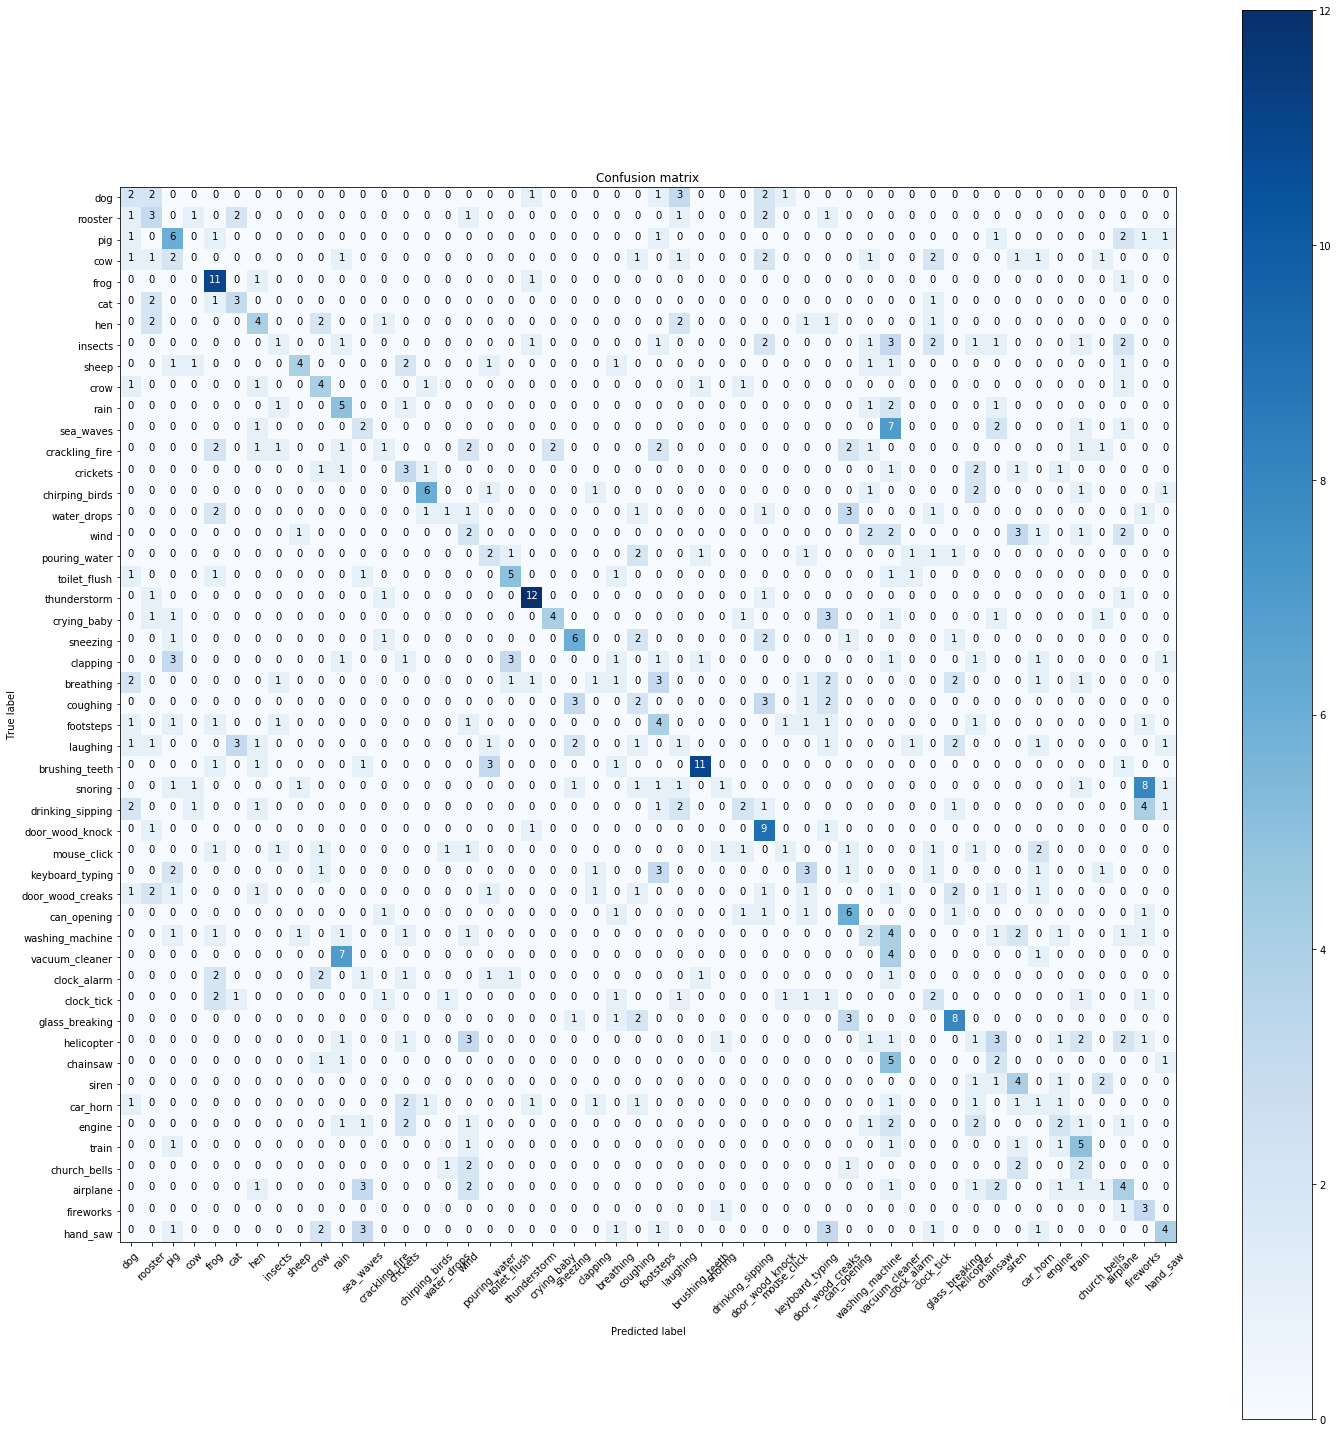

In [24]:
pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, pred))
cm = metrics.confusion_matrix(y_test, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [25]:
y_test = y_test.reset_index(drop=True)

In [26]:
X_test = X_test.reset_index(drop=True)

In [27]:
%%time

predictions = []
full_targets = []
start_time = time.time()
pred_probs = []
time_per_file = []

for data_iloc in range(0,len(y_test)):
    s_time = time.time()
    x_file = X_test[X_test.index == data_iloc]
    
    y_file = y_test[data_iloc]
    
    pred = clf.predict(x_file)
    predictions.append(pred)
    
    full_targets.append(y_file)
    time_per_file.append(time.time() - s_time)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tAverage File Time: " + str(np.average(time_per_file)))
print("\tProcessing Time: " + str(time.time() - start_time))

	File Time: 1.0611939430236816
	File Time: 0.4700353145599365
	File Time: 0.4447600841522217
	File Time: 0.45461177825927734
	File Time: 0.4596390724182129
	File Time: 0.45457887649536133
	File Time: 0.4648160934448242
	File Time: 0.48995423316955566
	File Time: 0.5516891479492188
	File Time: 0.46765613555908203
	File Time: 0.46651124954223633
	File Time: 0.4636552333831787
	File Time: 0.6777405738830566
	File Time: 0.44994306564331055
	File Time: 0.6029162406921387
	File Time: 0.5694036483764648
	File Time: 0.4944303035736084
	File Time: 0.44725561141967773
	File Time: 0.6019766330718994
	File Time: 0.5028116703033447
	File Time: 0.5787022113800049
	File Time: 0.6992442607879639
	File Time: 0.4797189235687256
	File Time: 0.6777377128601074
	File Time: 0.45623302459716797
	File Time: 0.4831678867340088
	File Time: 0.46477246284484863
	File Time: 0.6539933681488037
	File Time: 0.48058509826660156
	File Time: 0.5870015621185303
	File Time: 0.5060234069824219
	File Time: 0.469603776931762

	File Time: 0.6385700702667236
	File Time: 0.6200940608978271
	File Time: 0.6283974647521973
	File Time: 0.46871137619018555
	File Time: 0.46099328994750977
	File Time: 0.4752345085144043
	File Time: 0.47986555099487305
	File Time: 0.4548776149749756
	File Time: 0.642380952835083
	File Time: 0.4786386489868164
	File Time: 0.4628775119781494
	File Time: 0.4715864658355713
	File Time: 0.7982897758483887
	File Time: 0.4828197956085205
	File Time: 0.4752223491668701
	File Time: 0.5665345191955566
	File Time: 0.5583353042602539
	File Time: 0.4768557548522949
	File Time: 0.44588136672973633
	File Time: 0.4659109115600586
	File Time: 0.4948735237121582
	File Time: 0.45147252082824707
	File Time: 0.5543808937072754
	File Time: 0.7889375686645508
	File Time: 0.5258376598358154
	File Time: 0.45899200439453125
	File Time: 0.5798952579498291
	File Time: 0.5073816776275635
	File Time: 0.457078218460083
	File Time: 0.46082472801208496
	File Time: 0.6946830749511719
	File Time: 0.5070827007293701
	Fi

	File Time: 0.6174032688140869
	File Time: 0.5736992359161377
	File Time: 0.45173072814941406
	File Time: 0.4420294761657715
	File Time: 0.5796809196472168
	File Time: 0.5851995944976807
	File Time: 0.5117299556732178
	File Time: 0.4606814384460449
	File Time: 0.4939446449279785
	File Time: 0.5138256549835205
	File Time: 0.43637514114379883
	File Time: 0.6174302101135254
	File Time: 0.4462883472442627
	File Time: 0.45243072509765625
	File Time: 0.5667123794555664
	File Time: 0.559255838394165
	File Time: 0.503443717956543
	File Time: 0.450974702835083
	File Time: 0.46552371978759766
	File Time: 0.43494534492492676
	File Time: 0.4443814754486084
	File Time: 0.6339404582977295
	File Time: 0.7907392978668213
	File Time: 0.7056362628936768
	File Time: 0.5841512680053711
	File Time: 0.5205566883087158
	File Time: 0.4592585563659668
	File Time: 0.46178650856018066
	File Time: 0.6439433097839355
	File Time: 0.500199556350708
	File Time: 0.44202280044555664
	File Time: 0.4450514316558838
	File

0.25487256371814093
0.250376919863762
Confusion matrix, without normalization
[[2 2 0 ... 0 0 0]
 [1 3 0 ... 0 0 0]
 [1 0 6 ... 2 1 1]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 1 3 0]
 [0 0 1 ... 0 0 4]]


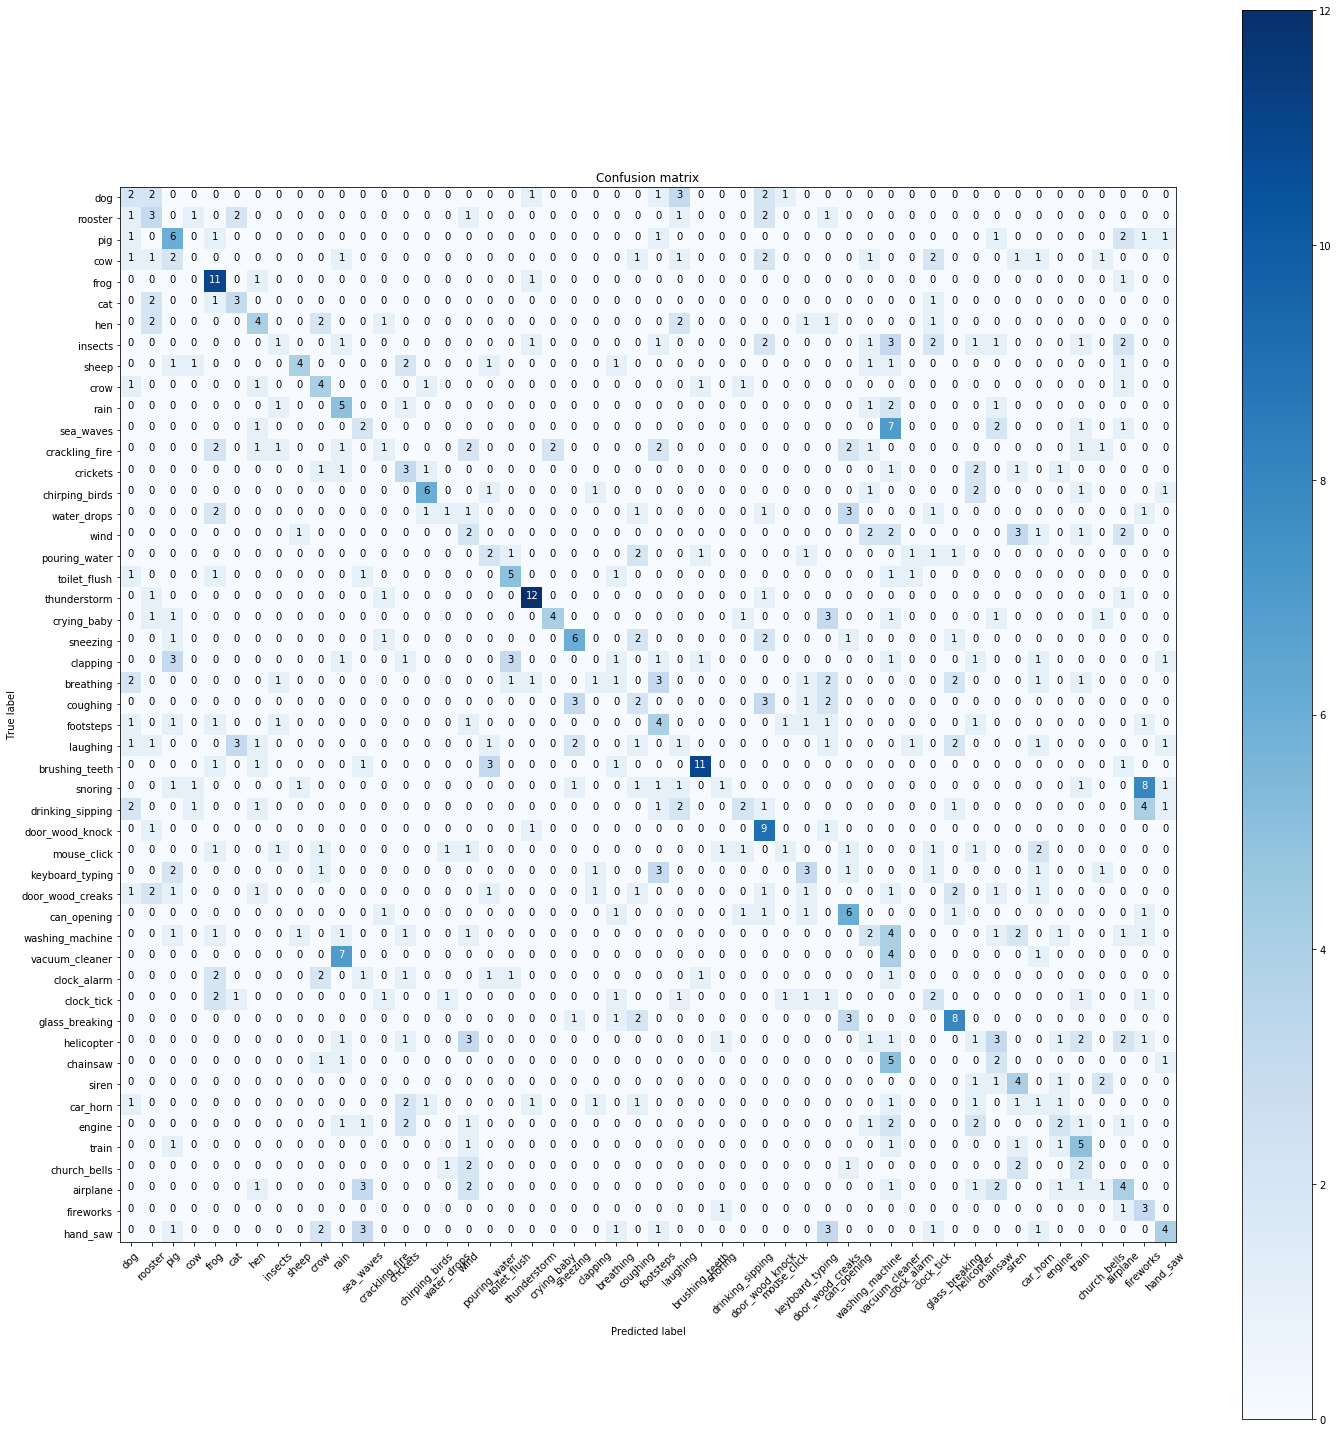

In [28]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [29]:
%%time
from sklearn.model_selection import cross_validate

clf = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=50, 
                       batch_size=35, 
                       validation_split=0.15)

scores = cross_validate(clf, X_train, y_train, cv=3, scoring=['accuracy', 'precision_macro', 'recall_macro'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
__________

755/755 [==============================] - 0s 183us/step - loss: 1.2909 - acc: 0.5669 - val_loss: 4.8773 - val_acc: 0.2239
Epoch 48/50
755/755 [==============================] - 0s 161us/step - loss: 1.2255 - acc: 0.5907 - val_loss: 4.7487 - val_acc: 0.2090
Epoch 49/50
755/755 [==============================] - 0s 167us/step - loss: 1.2720 - acc: 0.6026 - val_loss: 4.8689 - val_acc: 0.2164
Epoch 50/50
755/755 [==============================] - 0s 139us/step - loss: 1.2408 - acc: 0.6106 - val_loss: 4.7390 - val_acc: 0.2090
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
__________

In [30]:
clf.fit(X_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_42 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
__________

In [31]:
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,train_accuracy,train_precision_macro,train_recall_macro
0,9.289159,0.721846,0.202247,0.191020,0.206790,0.801802,0.830701,0.795381
1,9.354870,0.731282,0.182432,0.178470,0.197618,0.813273,0.836164,0.805404
2,9.512834,0.868925,0.171171,0.204442,0.182586,0.768279,0.794326,0.766766


In [32]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)

    predictions = []
    test = df[df.fold == 1]

    for data_iloc in range(0,len(X_test)):
        x_file = X_test[X_test.index == data_iloc]
    
        y_file = y_test[data_iloc]
        
        y_file = dataset.iloc[data_iloc].h_target
        yy_file = dataset.iloc[data_iloc].target

        predictions.append({
            'file': dataset.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': np.average(clf.predict_proba(x_file)[:,l_l]),
            'prediction': clf.predict(x_file)
        })
    
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    return predictions

In [33]:
%%time
preds = query_dataset('dog')

CPU times: user 6min 13s, sys: 1.06 s, total: 6min 14s
Wall time: 6min 13s


In [34]:
preds.head()

,ds_id,file,prediction,prob
0,30,1-12653-A-15.wav,[0],0.847420
1,89,1-19840-A-36.wav,[0],0.788584
2,172,1-32373-B-35.wav,[0],0.748931
3,161,1-30709-C-23.wav,[0],0.644227
4,296,1-59513-A-0.wav,[0],0.630938


In [35]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    print(query)
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
    print(misclass)
    print()
    return (count - len(misclass))/count

In [36]:
# Checking index
check_accuracy(preds, 'dog', 10)

dog
['water_drops', 'vacuum_cleaner', 'washing_machine', 'breathing', 'breathing', 'siren', 'crow', 'vacuum_cleaner', 'pig']



0.1

In [ ]:
accuracies = []
for cls in classes:
    %time preds = query_dataset(cls)
    %time acc = check_accuracy(preds, cls, 10)
    print(cls)
    print(acc)
    print()
    accuracies.append(acc)
    


CPU times: user 6min 16s, sys: 1.26 s, total: 6min 17s
Wall time: 6min 16s
dog
['water_drops', 'vacuum_cleaner', 'washing_machine', 'breathing', 'breathing', 'siren', 'crow', 'vacuum_cleaner', 'pig']

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.02 ms
dog
0.1

CPU times: user 6min 15s, sys: 1.46 s, total: 6min 17s
Wall time: 6min 15s
rooster
['breathing', 'airplane', 'vacuum_cleaner', 'vacuum_cleaner', 'fireworks', 'helicopter', 'pig', 'fireworks', 'siren', 'glass_breaking']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 6.54 ms
rooster
0.0

CPU times: user 6min 19s, sys: 1.24 s, total: 6min 20s
Wall time: 6min 19s
pig
['keyboard_typing', 'door_wood_knock', 'crow', 'keyboard_typing', 'brushing_teeth', 'vacuum_cleaner', 'rooster', 'clock_alarm', 'sheep', 'pouring_water']

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.4 ms
pig
0.0

CPU times: user 6min 10s, sys: 1.55 s, total: 6min 12s
Wall time: 6min 11s
cow
['siren', 'insects', 'crackling_fire', 'hen'

CPU times: user 5min 21s, sys: 2.34 s, total: 5min 23s
Wall time: 5min 21s
snoring
['insects', 'car_horn', 'washing_machine', 'church_bells', 'rooster', 'mouse_click', 'crackling_fire', 'mouse_click', 'pig', 'footsteps']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.94 ms
snoring
0.0

CPU times: user 5min 1s, sys: 4.08 s, total: 5min 5s
Wall time: 5min
drinking_sipping
['pouring_water', 'rain', 'vacuum_cleaner', 'can_opening', 'crickets', 'pig', 'keyboard_typing', 'cow', 'sheep', 'sneezing']

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.31 ms
drinking_sipping
0.0

CPU times: user 5min, sys: 3.8 s, total: 5min 4s
Wall time: 4min 59s
door_wood_knock
['airplane', 'breathing', 'clock_alarm', 'snoring', 'frog', 'vacuum_cleaner', 'dog', 'vacuum_cleaner', 'footsteps']

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.74 ms
door_wood_knock
0.1

CPU times: user 5min 19s, sys: 3.18 s, total: 5min 22s
Wall time: 5min 19s
mouse_click
['frog', 'footsteps', 'hen', 

In [39]:
np.average(accuracies)

0.022000000000000002